# Trade between DACH and Latin America
by [Bernardo Romero](mailto:bromero@americasmi.com)
October 2018

<a id='contents'></a>
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#sources">Sources</a></li>
</ul>


<a id='intro'></a>
## 1. Introduction
This jupyter notebook contains the steps to perform an exploratory data analysis of trade data between Germany, Switzerland Austria (Collectively known as "DACH" and Latin America). The analysis uses python and its some of its main libraries like pandas, numpy and matplotlib. The original data was dowloaded in zip files to a local directory from Harvard Univeristy's <a href="http://atlas.cid.harvard.edu/">Atlas of Economic Complexity</a>, which in turn uses data from the <a href="https://comtrade.un.org/"> UN Comtrade database</a>.

<a id='wrangling'></a>
## 2. Prepare the environment, import the files and prepare an analytical dataframe

In [2]:
# We start by importing the necessary pandas library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
%config InlineBackend.figure_format = 'svg'

In [133]:
# I saved the .zip files corresponding to a ten year period to a local directory and now I read them from there.Using the glob module I parse the files and create
# one very large file with basically all commodities trade flows in the world for those years, as reported by each country.

path ='data/' # use your path
allFiles = glob.glob(path + "country_partner_hsproduct4digit_year_*.zip")
trade = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, sep=',', header=0)
    list_.append(df)

trade = pd.concat(list_)

In [170]:
# we can have a look at the first rows of this new dataset
trade.head()

,year,export_value,import_value,hs_eci,hs_coi,sitc_eci,sitc_coi,pci,location_code,location_name_short_en,partner_code,partner_name_short_en,hs_product_code,hs_product_name_short_en
0,2007,1417,0,-0.033234,-1.025246,0.306005,-0.826179,1.507975,ABW,Aruba,AGO,Angola,8421,Centrifuges
1,2007,466,0,-0.602663,-0.870423,-0.414193,-0.626960,1.507975,AFG,Afghanistan,AGO,Angola,8421,Centrifuges
2,2007,2403,0,1.205567,0.603521,1.153777,0.920280,1.507975,AND,Andorra,AGO,Angola,8421,Centrifuges
3,2007,694879,0,0.145968,-0.567123,-0.369051,-0.815190,1.507975,ARE,United Arab Emirates,AGO,Angola,8421,Centrifuges
4,2007,5647,0,0.075159,0.498849,-0.041538,0.812893,1.507975,ARG,Argentina,AGO,Angola,8421,Centrifuges


In [135]:
# it's a quite large dataset. Here we count rows and columns. THere are 37.8 million records.
trade.shape

(37803762, 14)

In [136]:
# its a very interesting set of data, but we will first only use trade flows from DACH countries
dach = trade.query("location_code == 'DEU' | location_code == 'AUT' | location_code == 'CHE'")

In [137]:
# to prepare the file for joining it to another one, I make the columns "partner_code" and "location_code" lower case
dach['partner_code'] = dach['partner_code'].str.lower()
dach['location_code'] = dach['location_code'].str.lower()

D:\Anaconda3\envs\analytics\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\envs\analytics\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [138]:
# I now import the geographies.csv file into a second dataframe. This file contains geographic grouping by country that 
# will help analize data for Latin America as a whole. I also remove spaces from the columns to make the coding easier 
geography = pd.read_csv('geographies.csv')
geography.columns = geography.columns.str.strip().str.lower().str.replace(' ', '_')
geography.head()

,geo,name,four_regions,eight_regions,six_regions,members_oecd_g77,latitude,longitude,un_member_since,world_bank_region,world_bank_income_group_2017
0,afg,Afghanistan,asia,asia_west,south_asia,g77,33.00000,66.00000,19.11.1946,South Asia,Low income
1,alb,Albania,europe,europe_east,europe_central_asia,others,41.00000,20.00000,14.12.1955,Europe & Central Asia,Upper middle income
2,dza,Algeria,africa,africa_north,middle_east_north_africa,g77,28.00000,3.00000,8.10.1962,Middle East & North Africa,Upper middle income
3,and,Andorra,europe,europe_west,europe_central_asia,others,42.50779,1.52109,28.7.1993,Europe & Central Asia,High income
4,ago,Angola,africa,africa_sub_saharan,sub_saharan_africa,g77,-12.50000,18.50000,1.12.1976,Sub-Saharan Africa,Lower middle income


In [152]:
# we can now join the two dataframes using the partner_code column and adding the world_bank_region column to the trade data...
dach = dach.join(geography[['geo', 'world_bank_region']].set_index('geo'), on='partner_code', how='inner')

In [153]:
# ...and now we filter the dataframe to keep only data related to Latin America and the Caribbean 
dach_latam = dach.query('world_bank_region == "Latin America & Caribbean"')

In [154]:
# finally, we add a column to classify each country according to its main trading bloc (e.g. Mercosur, Pacific Alliance...)

def f(row):
    if row['partner_name_short_en'] in ('Mexico', 'Colombia', 'Chile', 'Peru'):
        val = 'Pacific Alliance'
    elif row['partner_name_short_en'] in ('Brazil', 'Argentina', 'Uruguay', 'Paraguay'):
        val = 'Mercosur'
    elif row['partner_name_short_en'] in ('Guatemala', 'El Salvador', 'Honduras', 'Nicaragua', 'Costa Rica', 'Panama', 'Dominican Republic', 'Belize'):
        val = 'SICA'
    else:
        val = 'other'
    return val

dach_latam['trade_bloc'] = dach_latam.apply(f, axis=1)
dach_latam.head()

D:\Anaconda3\envs\analytics\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,year,export_value,import_value,hs_eci,hs_coi,sitc_eci,sitc_coi,pci,location_code,location_name_short_en,partner_code,partner_name_short_en,hs_product_code,hs_product_name_short_en,world_bank_region,trade_bloc
129,2007,92258,0,2.16553,-3.638876,2.156432,-3.207801,1.507975,deu,Germany,atg,Antigua and Barbuda,8421,Centrifuges,Latin America & Caribbean,other
13946,2007,99059,0,2.09587,0.386842,2.108003,0.395645,0.402143,che,Switzerland,atg,Antigua and Barbuda,9999,Commodities not specified according to kind,Latin America & Caribbean,other
13948,2007,27076,0,2.16553,-3.638876,2.156432,-3.207801,0.402143,deu,Germany,atg,Antigua and Barbuda,9999,Commodities not specified according to kind,Latin America & Caribbean,other
28201,2007,4011,0,2.16553,-3.638876,2.156432,-3.207801,1.066792,deu,Germany,atg,Antigua and Barbuda,4016,Other articles of vulcanized rubber,Latin America & Caribbean,other
42232,2007,6017,0,2.16553,-3.638876,2.156432,-3.207801,-0.811097,deu,Germany,atg,Antigua and Barbuda,6403,Leather footwear,Latin America & Caribbean,other


In [155]:
# let's save this data to a csv file to save some time and bandwith in future runs. I use a semicolon as separator because it's
# the default in Europe
dach_latam.to_csv('dach_latam.csv', sep=';', index=False)

###  Cheking for data quality

In [143]:
dach_latam = pd.read_csv('dach_latam.csv', sep=';')

In [156]:
# how big is the dataset: roughly 330K rows and 17 columns
dach_latam.shape

(330237, 16)

In [145]:
# are there any null values? No, it's a complete dataset
dach_latam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330237 entries, 0 to 330236
Data columns (total 16 columns):
year                        330237 non-null int64
export_value                330237 non-null int64
import_value                330237 non-null int64
hs_eci                      330237 non-null float64
hs_coi                      330237 non-null float64
sitc_eci                    330237 non-null float64
sitc_coi                    330237 non-null float64
pci                         330235 non-null float64
location_code               330237 non-null object
location_name_short_en      330237 non-null object
partner_code                330237 non-null object
partner_name_short_en       330237 non-null object
hs_product_code             330237 non-null object
hs_product_name_short_en    330237 non-null object
world_bank_region           330237 non-null object
trade_bloc                  330237 non-null object
dtypes: float64(5), int64(3), object(8)
memory usage: 40.3+ MB


In [183]:
# are there any null values? No, it's a complete dataset
trade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37803762 entries, 0 to 3914343
Data columns (total 14 columns):
year                        int64
export_value                int64
import_value                int64
hs_eci                      float64
hs_coi                      float64
sitc_eci                    float64
sitc_coi                    float64
pci                         float64
location_code               object
location_name_short_en      object
partner_code                object
partner_name_short_en       object
hs_product_code             object
hs_product_name_short_en    object
dtypes: float64(5), int64(3), object(6)
memory usage: 5.5+ GB


In [147]:
# there's also no duplicated rows
sum(dach_latam.duplicated())

0

<a id='eda'></a>
## 3. Exploratory Data Analysis

In [157]:
# in a new dataframe we calculate DACH export values by year and by each of the seven World Bank regions 

dach_regions = dach.groupby(['year','world_bank_region'])['export_value'].sum().reset_index()
dach_regions.head(7)

,year,world_bank_region,export_value
0,2007,East Asia & Pacific,148585682667
1,2007,Europe & Central Asia,1229190294101
2,2007,Latin America & Caribbean,35028869320
3,2007,Middle East & North Africa,54384095093
4,2007,North America,136227195079
5,2007,South Asia,20515450486
6,2007,Sub-Saharan Africa,17979300204


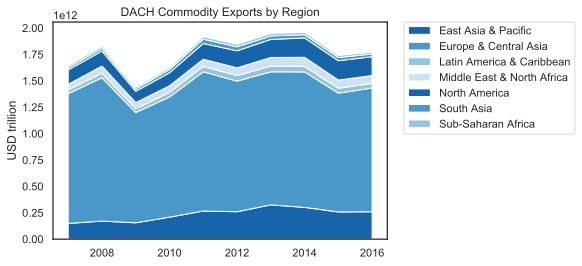

In [158]:
# we now plot DACH's export values per region and year

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
y1 = dach_regions[dach_regions['world_bank_region']== 'East Asia & Pacific']['export_value']
y2 = dach_regions[dach_regions['world_bank_region']== 'Europe & Central Asia']['export_value']
y3 = dach_regions[dach_regions['world_bank_region']== 'Latin America & Caribbean']['export_value']
y4 = dach_regions[dach_regions['world_bank_region']== 'Middle East & North Africa']['export_value']
y5 = dach_regions[dach_regions['world_bank_region']== 'North America']['export_value']
y6 = dach_regions[dach_regions['world_bank_region']== 'South Asia']['export_value']
y7 = dach_regions[dach_regions['world_bank_region']== 'Sub-Saharan Africa']['export_value']
labels = ['East Asia & Pacific', 'Europe & Central Asia', 'Latin America & Caribbean', 'Middle East & North Africa', 'North America', 'South Asia', 'Sub-Saharan Africa']
x = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

ax = plt.stackplot(x,y1,y2,y3,y4, y5, y6, y7, labels=labels)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('DACH Commodity Exports by Region')
plt.ylabel('USD trillion')
plt.show()

In [161]:
# We create a table with all Latin American trading partners for DACH in 2016
# I used this table to create a treemap in Excel. Unfortunately, I still haven't found a way to do a descent treemap in Python. 
# A nice result can be achieved in R using ggplot

dach_latam_16 = dach_latam[dach_latam['year']==2016].groupby(['location_name_short_en', 'partner_name_short_en'])['export_value'].sum().reset_index()
dach_latam_16.to_csv('exports_dach_to_latam_2016.csv', sep=';', index=False)

This is the result I would have liked to achieve in Python, but had to do in MS Excel:

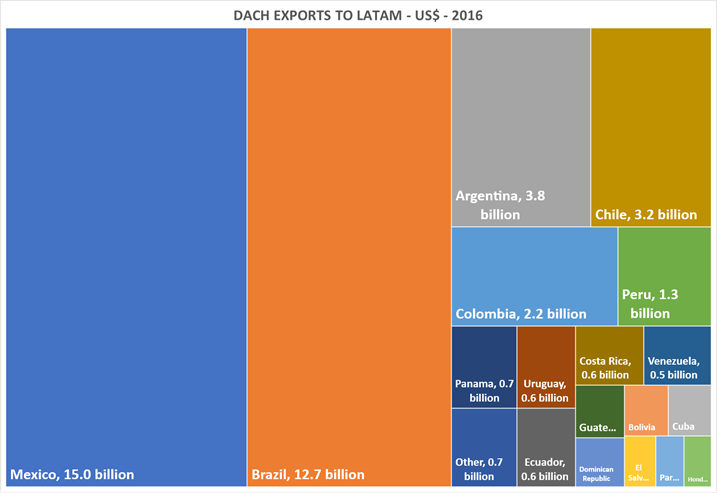

In [162]:
# We now calculate value of exports per trade bloc for DACH countries as a group 
df = dach_latam.groupby(['year','trade_bloc'])['export_value'].sum().reset_index()

Text(0.5, 0, 'Year')

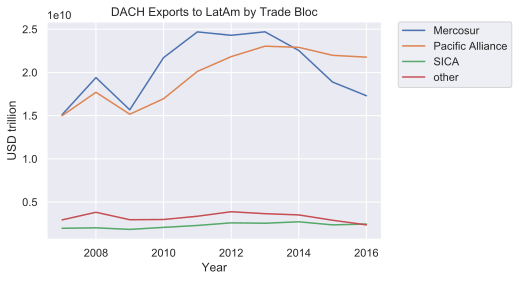

In [163]:
# we now plot the data to see the evolution in trade from DACH countries to several trading blocs

sns.set(style="darkgrid")
df.pivot(index='year', columns='trade_bloc', values='export_value').plot();
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('DACH Exports to LatAm by Trade Bloc')
plt.ylabel('USD trillion')
plt.xlabel('Year')

In [164]:
# we prepare a dataframe with aggregated data by Year and Exports Origin Country. We want to see the timeseries for each country
df2 = dach_latam.groupby(['year','location_name_short_en'])['export_value'].sum().reset_index()

In [165]:
# we create separate datasets for each country in DACH

ger = df2[df2['location_name_short_en']=='Germany']
aut = df2[df2['location_name_short_en']=='Austria']
che = df2[df2['location_name_short_en']=='Switzerland']

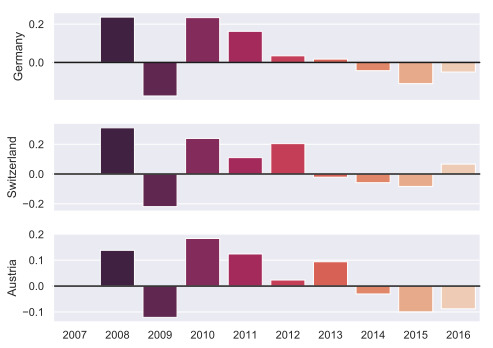

In [166]:
# and now we use that data to plot the evolution of exports to Latin America by country of origin in DACH


# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

# Generate chart for Germany
x = df2.year.unique()
y1 = ger.export_value.pct_change().values # the values are expressed in percentage change from a year before
sns.barplot(x=x, y=y1, palette="rocket",ax=ax1)

ax1.axhline(0, color="k",  clip_on=False)
ax1.set_ylabel("Germany")

# Generate the chart for Switzerland
y2 = aut.export_value.pct_change().values
sns.barplot(x=x, y=y2, palette="rocket", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Switzerland")

# Generate the chart for Austria
y3 = che.export_value.pct_change().values
sns.barplot(x=x, y=y3, palette="rocket", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Austria")

# Finalize the plot
sns.despine(bottom=True)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=1)



In [15]:
# we now turn the attention to the export flows from key Latin American economies to DACH countries for 2016
countries = ['BRA','MEX','COL','PER','ARG','CHL']
years = ['2016']
lat_expo = trade[trade.location_code.isin(countries) & trade.year.isin(years)].groupby(['location_name_short_en','partner_name_short_en']).agg({'export_value':sum})

In [23]:
# We group by largest export destinations for the selected group of countries
g = lat_expo['export_value'].groupby(level=0, group_keys=False)
res = g.nlargest(10)
res

location_name_short_en  partner_name_short_en   
Argentina               Brazil                        9043964218
                        China                         4615674896
                        United States of America      4550083885
                        Vietnam                       2543511198
                        Chile                         2366647729
                        India                         2344043600
                        Egypt                         1791719071
                        Germany                       1668615618
                        Spain                         1615847352
                        Paraguay                      1429187079
Brazil                  China                        39274592959
                        United States of America     24566386905
                        Argentina                    13485361159
                        Netherlands                  10322772245
                        Germany          

<a id='conclusions'></a>
## 4. Conclusions

Trade flow between Latin America and German-speaking countries is relatively low. As an example, only 2,6% (USD 36.9 billion) of German commodity exports and 2,2% (USD 6,6 billion) of Switzerland’s were shipped to LatAm in 2017, according to the UN Comtrade database. LatAm’s share of Austria’s exports for 2016, its most recent available year, was only 1,9% (USD 3 billion).
Over the years, this proportion has not changed much. The chart below shows how Latin America remains a less frequent destination for DACH’s goods than the Middle East and North Africa. As expected, European countries are by far the main destination of DACH’s commodity exports, followed by East Asia and North America (excluding Mexico).


As could be expected from their predominant weight in Latin America, Mexico and Brazil are DACH’s main export destinations in Latin America. Combined, they received in 2016 63% of all exports to the region coming from Germany, Switzerland and Austria. Configuring a second group in importance for DACH’s exports, Argentina, Chile, Colombia and Peru represent together further 24%, whereas a large group of further 27 countries receive the remaining 13%.

Exports from Austria and Germany did not grow between 2014 and 2016, whereas Switzerland managed to increase its commodities exports to Latin America and the Caribbean in 2016

Germany is a top-five export market for Brazil, Mexico and Colombia, which is representative of the size of the German economy. Switzerland has a special trading relationship with Peru, being its third largest exports destination mainly because of the gold trade, whereas Austria is low on the list of LatAm’s export destinations, being particularly low for Brazil in the 95th position. 

Commodity exports from DACH towards Mercosur, Pacific Alliance and SICA were heavily affected by the 2008 financial crisis. In 2010 exports quickly rebounded, especially to Mercosur countries. However, economic recession and political crisis hit Brazil in 2014, which marked a turning point in DACHs exports to Mercosur, from which it only started recovering in 2017. Exports of Germany, Switzerland and Austria have found a more stable destination in the Pacific Alliance, which as a group displaced Mercosur from the top spot in Latin America. 

## 5. Sources
* https://comtrade.un.org/
* https://atlas.cid.harvard.edu/
* https://www.gapminder.org/